<a href="https://colab.research.google.com/github/Johnnyr81/DS-Unit-2-Regression-Classification/blob/master/module4/assignment_regression_classification_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 4

## Assignment

- [ ] Watch Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes) to learn about the mathematics of Logistic Regression.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Do one-hot encoding. (Remember it may not work with high cardinality categoricals.)
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your coefficients.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.


## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- [ ] Make exploratory visualizations.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from the previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

#### Pipelines

[Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/compose.html) explains why pipelines are useful, and demonstrates how to use them:

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

### Reading
- [ ] [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)
- [ ] [Always start with a stupid model, no exceptions](https://blog.insightdatascience.com/always-start-with-a-stupid-model-no-exceptions-3a22314b9aaa)
- [ ] [Statistical Modeling: The Two Cultures](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module4')

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 7.1MB 40.0MB/s 
     |████████████████████████████████| 614kB 36.3MB/s 
     |████████████████████████████████| 225kB 41.1MB/s 
     |████████████████████████████████| 768kB 37.7MB/s 
     |████████████████████████████████| 51kB 19.7MB/s 
     |████████████████████████████████| 194kB 33.2MB/s 
     |████████████████████████████████| 737kB 39.6MB/s 
     |████████████████████████████████| 51kB 18.7MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=b68f89cc440c0155ad405add5af5eb0f5bdefc4ef15bc490c1ff646bddd52ae8
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=b02103e815eb070affbd5ebbf717ae3dd090f85ad9d0a3973c322dd65e8f816d
  Stored 

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd

train_features = pd.read_csv('../data/tanzania/train_features.csv')
train_labels = pd.read_csv('../data/tanzania/train_labels.csv')
test_features = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [13]:
y_train.tail()

59395    functional
59396    functional
59397    functional
59398    functional
59399    functional
Name: status_group, dtype: object

In [15]:
majority_class = y_train.mode()[0]
majority_class

'functional'

In [16]:
len(y_train)

59400

In [11]:
y_train =train_labels['status_group']
y_train.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### Train/validate/test split with the Tanzania Waterpumps data.

In [0]:
from sklearn.model_selection import train_test_split

X_train = train_features
y_train = train_labels['status_group']

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42) 

### Do one-hot encoding and logistic regression

In [0]:
X_train.describe(exclude='number').T.sort_values(by='unique')

In [0]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [37]:
categorical_features = ['quantity']
numeric_features = X_train.select_dtypes('number').columns.drop('id').tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_subset)
X_val_encoded = encoder.transform(X_val_subset)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Validation Accuracy 0.6585016835016835


###Get & plot coefficients

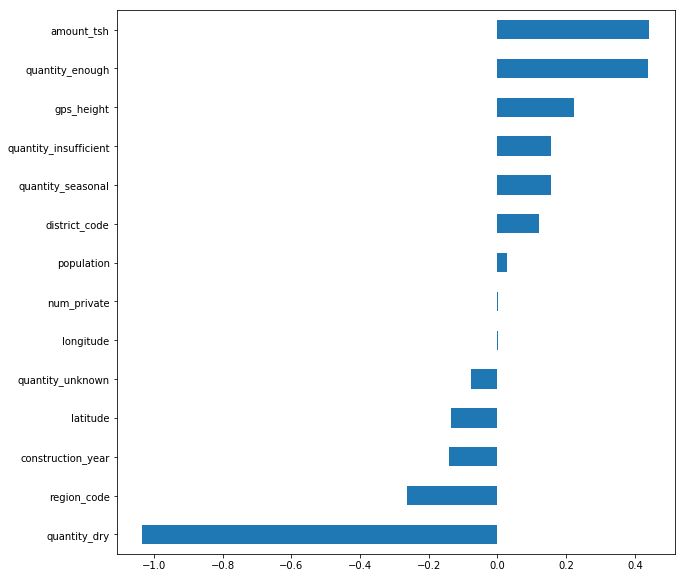

In [39]:
import matplotlib.pyplot as plt

functional_coefficients = pd.Series(
    model.coef_[0],
    X_train_encoded.columns
)

plt.figure(figsize=(10, 10))
functional_coefficients.sort_values().plot.barh();

###Submission

In [0]:
X_test_subset = test_features[features]
X_test_encoded = encoder.transform(X_test_subset)
X_test_scaled = scaler.transform(X_test_encoded)
assert all(X_test_encoded.columns == X_train_encoded.columns)

In [0]:
y_pred = model.predict(X_test_scaled)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [43]:
!head submission-01.csv

id,status_group
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,non functional


In [0]:
if in_colab:
    from google.colab import files
    files.download('submission-01.csv')